In [2]:
library(ppcor)
#install.packages('lmPerm')
library(lmPerm)
library(psych)
library(car)
library(ggplot2)
library(lme4)
library(mediation)
library(caret)
library(gbm)
library(party)
library(Metrics)
#install.packages("wesanderson")
library(wesanderson)
library(gtools)
library(interactions)
#install.packages('ggstance')
library(ggstance)
#install.packages('elasticnet')
library(elasticnet)
#install.packages('kernlab')
library(kernlab)
#install.packages('e1071')
library(e1071)
#install.packages('MatchIt')
library(MatchIt)
library(dplyr)
library(ukbtools)
library(mediation)
library(lavaan)
library(lavaanPlot)
library(plotly)
library(MVN)
#install.packages('MissMech')
library(semTools)
library(MissMech)
#install.packages('aod')
library(aod)
options(warn=-1)

# Read in the data 

In [3]:
di=read.table('/dagher/dagher11/filip/PRSOB/data/brain_data.csv', header=TRUE, na.strings = "", sep=',', quote = "\"")
cov19=read.table('/dagher/dagher11/filip/COVID/data/covid19_result.txt', header=TRUE, na.strings = "", sep='\t', quote = "\"")
cov19= cov19[order(cov19$result, decreasing=TRUE),] 

covidinf=cov19
covidinf=covidinf[!duplicated(covidinf$eid),]
cov_base=covidinf
cov19$date=as.Date( as.character(cov19$specdate), "%d/%m/%y")
cov19 <- subset(cov19, date <= as.Date("2020-04-26") ) # filter participants before April 26th
cov19=cov19[!duplicated(cov19$eid),]

death=read.table('/dagher/dagher11/filip/COVID/data/death_cause.txt', header=TRUE, na.strings = "", sep='\t', quote = "\"")
death=(death[death$level==1 & death$cause_icd10=='U071',]) # take only individuals whose primary cause of death was COVID

## Add hypertension and diabetes diagnosis

In [4]:
di$hypertension <- 0
for (i in as.numeric(grep('vascularheart_problems_diagnosed_by_doctor', colnames(di)))) { 
    di$hypertension[di[i] == 'High blood pressure'] <- 1 # Hypertension
}

# Mark participants who have diabetes - self-reported
di$diabetes <- 0
for (i in as.numeric(grep('diabetes_diagnosed_by_doctor', colnames(di)))) { 
    di$diabetes[di[i] =="Yes"] <- 1
}

# Mark participants with hypertension - diagnosed
di$hypertension2 <- 0
for (i in as.numeric(grep('icd10', colnames(di)))) { 
    di$hypertension2[di[i] == 'I10 Essential (primary) hypertension'] <- 1 # Hypertension
    }

# Mark participants who have diabetes - diagnoses
exclusions_diabetes=c('^E10','^E11','^E12','^E13','^E14')
di$diabetes2 <- NA
for (i in as.numeric(grep('icd10', colnames(di)))) {
    for (d in 1:length(exclusions_diabetes)) {
        di$diabetes2[grepl(exclusions_diabetes[d], di[[i]])] = 1
    }
}

di$Hypertension=0
di$Hypertension[di$hypertension=='1' | di$hypertension2=='1']=1
di$Diabetes=0
di$Diabetes[di$diabetes=='1' | di$diabetes2=='1']=1

# MetS latent variable and OR - covid infection

## Create dataframes

In [23]:
covidinf=merge(di, covidinf, by='eid')

covidinf$TG=(log(covidinf$triglycerides_30870.0.0))
covidinf$HDL=(log(covidinf$hdl_cholesterol_30760.0.0))
covidinf$Sex=as.factor(covidinf$sex_31.0.0)
covidinf$Waist=(covidinf$waist_circumference_48.0.0)
covidinf$HbA1c=(log(covidinf$glycated_haemoglobin_hba1c_30750.0.0))
covidinf$systolicBP=(rowMeans(cbind(covidinf$systolic_blood_pressure_automated_reading_4080.0.0,
                                      covidinf$systolic_blood_pressure_automated_reading_4080.0.1)))
covidinf$diastolicBP=(rowMeans(cbind(covidinf$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       covidinf$diastolic_blood_pressure_automated_reading_4079.0.1)))
covidinf$glucose=(log(covidinf$glucose_30740.0.0))
covidinf$CRP=(log(covidinf$c.reactive_protein_30710.0.0))


COVinf=select(covidinf, TG, HDL, Sex, Hypertension, Diabetes, result,
          laboratory, origin, spectype, qualifications_6138.0.0, townsend_deprivation_index_at_recruitment_189.0.0,
          Waist, year_of_birth_34.0.0, smoking_status_20116.0.0,
          ethnic_background_21000.0.0, HbA1c, systolicBP, diastolicBP, glucose,
             average_total_household_income_before_tax_738.0.0, sex_31.0.0, CRP, eid)



for (j in c(1, 2, 11, 12, 16, 17, 18, 19, 22)) { # 
    Q3=as.numeric(quantile(COVinf[j],0.75, na.rm=TRUE))
    Q1=as.numeric(quantile(COVinf[j],0.25, na.rm=TRUE))
    upper=Q3+(2.2*(Q3-Q1))
    lower=Q1-(2.2*(Q3-Q1))
    COVinf[j][COVinf[j]<lower]=NA
    COVinf[j][COVinf[j]>upper]=NA
    COVinf[j]=scale(COVinf[j])
}

COVinf=na.omit(COVinf)

COVinf$Hypertension=as.numeric(COVinf$Hypertension)
COVinf$Diabetes=as.numeric(COVinf$Diabetes)

nrow(COVinf)

[1] 12694

## Sample characteristics


In [7]:
char=merge(COVinf, covidinf, by='eid', all.x=TRUE)
table(char$result.x)/nrow(COVinf)
describe(char$year_of_birth_34.0.0.x)
table(char$sex_31.0.0.x)/nrow(COVinf)
describe(char$waist_circumference_48.0.0)
describe(char$glycated_haemoglobin_hba1c_30750.0.0)
describe(char$c.reactive_protein_30710.0.0)
describe(char$glucose_30740.0.0)
describe(char$hdl_cholesterol_30760.0.0)
describe(char$triglycerides_30870.0.0)
describe((rowMeans(cbind(char$systolic_blood_pressure_automated_reading_4080.0.0,
                                      char$systolic_blood_pressure_automated_reading_4080.0.1))))
describe(rowMeans(cbind(char$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       char$diastolic_blood_pressure_automated_reading_4079.0.1)))
table(char$Diabetes.x)/nrow(COVinf)
table(char$Hypertension.x)/nrow(COVinf) 


         0          1 
0.91003624 0.08996376 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,12694,1950.219,8.24585,1948,1949.652,8.8956,1937,1970,33,0.5247627,-0.8403309,0.07318737



   Female      Male 
0.5184339 0.4815661 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,12694,92.20652,13.72568,92,91.76294,13.3434,57,143,86,0.3287756,-0.01011325,0.1218245


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,12694,35.77413,4.348797,35.5,35.5563,3.7065,23.9,53.7,29.8,0.660301,1.43348,0.03859846


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,12694,2.862893,4.580452,1.51,1.93233,1.40847,0.08,71.31,71.23,5.639913,47.5749,0.04065455


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,12694,5.00098,0.6296372,4.935,4.958268,0.511497,3.292,7.572,4.28,0.8198222,1.628774,0.005588447


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,12694,1.426255,0.3816092,1.375,1.396975,0.3617544,0.511,3.524,3.013,0.8392112,1.096123,0.003387034


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,12694,1.770352,1.017863,1.523,1.622534,0.7798476,0.272,10.856,10.584,1.981756,6.836757,0.009034209


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,12694,138.4308,18.55492,137,137.6383,18.5325,87,205,118,0.4237954,0.06510899,0.1646872


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,12694,82.25807,9.968139,82,82.0831,9.6369,48,119.5,71.5,0.1806831,0.03373961,0.08847383



         0          1 
0.91980463 0.08019537 


        0         1 
0.5772018 0.4227982 

## CFA

In [8]:
COVID_infection = '
#Latent variables

BP =~ diastolicBP + systolicBP 
HypertensionLatent =~  BP + Hypertension
DiaSer =~ HbA1c + glucose 
DiabetesLatent =~ DiaSer + Diabetes
DysL =~ TG + HDL

MetS =~ Waist + DysL + HypertensionLatent + DiabetesLatent + CRP

'


COVID_fitinf <- cfa(COVID_infection, data=COVinf, estimator='MLM')
summary(COVID_fitinf, standardized=TRUE, fit.measures=T)
#fitmeasures(WMHOB_fit) #fit indices

lavaan 0.6-7 ended normally after 53 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         25
                                                      
  Number of observations                         12694
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                              1732.345    1634.453
  Degrees of freedom                                30          30
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  1.060
       Satorra-Bentler correction                                 

Model Test Baseline Model:

  Test statistic                             25819.749   22934.979
  Degrees of freedom                                45          45
  P-value                        

## Logistic regression

In [9]:
### Get latent variable scores

COVinf$MetS=(lavPredict(COVID_fitinf, newdata = NULL, type = "lv", method = "regression",
           se = "none", acov = "none", label = TRUE, fsm = FALSE, 
           append.data = FALSE, assemble = FALSE,
           level = 1L, optim.method = "bfgs", ETA = NULL))[,6]

### Run logistic regression

metsinf_logit=(glm(result ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
           MetS +
           sex_31.0.0 +
           year_of_birth_34.0.0 +
           laboratory +
           spectype +
           qualifications_6138.0.0 + 
           smoking_status_20116.0.0 + 
           ethnic_background_21000.0.0 +
           average_total_household_income_before_tax_738.0.0, data=COVinf, family='binomial'(link="logit")))

summary(metsinf_logit)


Call:
glm(formula = result ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
    MetS + sex_31.0.0 + year_of_birth_34.0.0 + laboratory + spectype + 
    qualifications_6138.0.0 + smoking_status_20116.0.0 + ethnic_background_21000.0.0 + 
    average_total_household_income_before_tax_738.0.0, family = binomial(link = "logit"), 
    data = COVinf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2443  -0.4651  -0.3841  -0.3154   2.7130  

Coefficients:
                                                                                 Estimate
(Intercept)                                                                    -7.358e+01
townsend_deprivation_index_at_recruitment_189.0.0                               1.002e-01
MetS                                                                            9.576e-02
sex_31.0.0Male                                                                  2.064e-01
year_of_birth_34.0.0                                                

# MetS latent variable and OR - covid mortality

## Create dataframes

In [5]:
covidinf=cov_base
covidinf=covidinf[!duplicated(covidinf$eid),]
covidinf=merge(di, covidinf, by='eid')
cov_pos=(covidinf[covidinf$result==1,]) # take only people who tested positive
coviddeath=merge(cov_pos, death, by='eid',all.x=T) # merge with death records
coviddeath$level[is.na(coviddeath$level)]=0 # recode

In [6]:
coviddeath$TG=scale(log(coviddeath$triglycerides_30870.0.0))
coviddeath$HDL=scale(log(coviddeath$hdl_cholesterol_30760.0.0))
coviddeath$Sex=as.factor(coviddeath$sex_31.0.0)
coviddeath$Waist=scale(coviddeath$waist_circumference_48.0.0)
coviddeath$HbA1c=scale(log(coviddeath$glycated_haemoglobin_hba1c_30750.0.0))
coviddeath$systolicBP=scale(rowMeans(cbind(coviddeath$systolic_blood_pressure_automated_reading_4080.0.0,
                                      coviddeath$systolic_blood_pressure_automated_reading_4080.0.1)))
coviddeath$diastolicBP=scale(rowMeans(cbind(coviddeath$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       coviddeath$diastolic_blood_pressure_automated_reading_4079.0.1)))
coviddeath$glucose=scale(log(coviddeath$glucose_30740.0.0))
coviddeath$CRP=scale(log(coviddeath$c.reactive_protein_30710.0.0))


COVinf=select(coviddeath, TG, HDL, Sex, Hypertension, Diabetes, result,
          laboratory, origin, spectype, qualifications_6138.0.0, townsend_deprivation_index_at_recruitment_189.0.0,
          Waist, year_of_birth_34.0.0, smoking_status_20116.0.0,
          ethnic_background_21000.0.0, HbA1c, systolicBP, diastolicBP, glucose,
             average_total_household_income_before_tax_738.0.0, sex_31.0.0, CRP, level, eid)



for (j in c(1, 2, 11, 12, 16, 17, 18, 19, 22)) { # 
    Q3=as.numeric(quantile(COVinf[j],0.75, na.rm=TRUE))
    Q1=as.numeric(quantile(COVinf[j],0.25, na.rm=TRUE))
    upper=Q3+(2.2*(Q3-Q1))
    lower=Q1-(2.2*(Q3-Q1))
    COVinf[j][COVinf[j]<lower]=NA
    COVinf[j][COVinf[j]>upper]=NA
    COVinf[j]=scale(COVinf[j])
}

COVinf=na.omit(COVinf)

COVinf$Hypertension=as.numeric(COVinf$Hypertension)
COVinf$Diabetes=as.numeric(COVinf$Diabetes)

nrow(COVinf)

[1] 1152

In [8]:
sum(COVinf$level)

[1] 180

## Sample characteristics

In [7]:
char=merge(COVinf, coviddeath, by='eid', all.x=TRUE)
table(char$level.x)/nrow(COVinf)
describe(char$year_of_birth_34.0.0.x)
table(char$sex_31.0.0.x)/nrow(COVinf)
describe(char$waist_circumference_48.0.0)
describe(char$glycated_haemoglobin_hba1c_30750.0.0)
describe(char$c.reactive_protein_30710.0.0)
describe(char$glucose_30740.0.0)
describe(char$hdl_cholesterol_30760.0.0)
describe(char$triglycerides_30870.0.0)
describe((rowMeans(cbind(char$systolic_blood_pressure_automated_reading_4080.0.0,
                                      char$systolic_blood_pressure_automated_reading_4080.0.1))))
describe(rowMeans(cbind(char$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       char$diastolic_blood_pressure_automated_reading_4079.0.1)))
table(char$Diabetes.x)/nrow(COVinf)
table(char$Hypertension.x)/nrow(COVinf)


      0       1 
0.84375 0.15625 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1152,1952.233,9.116566,1951,1952.022,11.8608,1937,1969,32,0.1703424,-1.339288,0.2685994



   Female      Male 
0.4713542 0.5286458 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1152,93.49913,13.92474,93,93.0449,13.3434,62,142,80,0.3340969,0.1326498,0.4102615


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1152,35.92943,4.742264,35.4,35.61291,3.85476,23.2,55.8,32.6,0.83618,1.677071,0.1397203


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1152,3.056293,5.529917,1.59,2.000087,1.490013,0.09,66.24,66.15,6.576974,57.48747,0.1629267


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1152,4.989932,0.6533124,4.916,4.939166,0.5426316,3.269,7.812,4.543,0.8741615,1.53822,0.0192484


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1152,1.361984,0.3438911,1.3185,1.337909,0.333585,0.511,2.954,2.443,0.7041892,0.6200674,0.01013199


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1152,1.79212,1.04119,1.526,1.643531,0.8050518,0.461,10.856,10.395,1.96041,7.555482,0.03067635


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1152,137.2839,18.53501,135,136.3682,18.5325,91.5,204.5,113,0.5184207,0.2161103,0.546093


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1152,82.49306,10.28478,82,82.33134,9.6369,48,118.5,70.5,0.2073127,0.2155851,0.3030182



         0          1 
0.90017361 0.09982639 


        0         1 
0.5807292 0.4192708 

## CFA

In [28]:
COVID_infection = '
#Latent variables

BP =~ diastolicBP + systolicBP 
HypertensionLatent =~  BP + Hypertension
DiaSer =~ HbA1c + glucose 
DiabetesLatent =~ DiaSer + Diabetes
DysL =~ TG + HDL

MetS =~ Waist + DysL + HypertensionLatent + DiabetesLatent + CRP




'

COVID_fitinf <- cfa(COVID_infection, data=COVinf, estimator='MLM')
summary(COVID_fitinf, standardized=TRUE, fit.measures=T)
#fitmeasures(WMHOB_fit) #fit indices

lavaan 0.6-7 ended normally after 52 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         25
                                                      
  Number of observations                          1152
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                               212.156     192.830
  Degrees of freedom                                30          30
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  1.100
       Satorra-Bentler correction                                 

Model Test Baseline Model:

  Test statistic                              2388.259    2096.981
  Degrees of freedom                                45          45
  P-value                        

### Get latent variable scores

In [29]:
COVinf$MetS=(lavPredict(COVID_fitinf, newdata = NULL, type = "lv", method = "regression",
           se = "none", acov = "none", label = TRUE, fsm = FALSE, 
           append.data = FALSE, assemble = FALSE,
           level = 1L, optim.method = "bfgs", ETA = NULL))[,6]

### Run logistic regression

In [30]:
metsinf_logit=(glm(level ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
           MetS +
           sex_31.0.0 +
           year_of_birth_34.0.0 +
           laboratory +
           spectype +
           qualifications_6138.0.0 + 
           smoking_status_20116.0.0 + 
           ethnic_background_21000.0.0 +
           average_total_household_income_before_tax_738.0.0, data=COVinf, family='binomial'(link="logit")))

summary(metsinf_logit)


Call:
glm(formula = level ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
    MetS + sex_31.0.0 + year_of_birth_34.0.0 + laboratory + spectype + 
    qualifications_6138.0.0 + smoking_status_20116.0.0 + ethnic_background_21000.0.0 + 
    average_total_household_income_before_tax_738.0.0, family = binomial(link = "logit"), 
    data = COVinf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5166  -0.6009  -0.3117  -0.1519   2.6361  

Coefficients:
                                                                                 Estimate
(Intercept)                                                                     2.354e+02
townsend_deprivation_index_at_recruitment_189.0.0                               1.197e-01
MetS                                                                            5.109e-01
sex_31.0.0Male                                                                  6.135e-02
year_of_birth_34.0.0                                                 

In [31]:
metsinf_logit_specfactors=(glm(level ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
           systolicBP + diastolicBP + Hypertension +
           glucose + HbA1c + Diabetes +
           HDL + TG +
           CRP +
           Waist +
           sex_31.0.0 +
           year_of_birth_34.0.0 +
           laboratory +
           spectype +
           qualifications_6138.0.0 + 
           smoking_status_20116.0.0 + 
           ethnic_background_21000.0.0 +
           average_total_household_income_before_tax_738.0.0, data=COVinf, family='binomial'(link="logit")))

summary(metsinf_logit_specfactors)


Call:
glm(formula = level ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
    systolicBP + diastolicBP + Hypertension + glucose + HbA1c + 
    Diabetes + HDL + TG + CRP + Waist + sex_31.0.0 + year_of_birth_34.0.0 + 
    laboratory + spectype + qualifications_6138.0.0 + smoking_status_20116.0.0 + 
    ethnic_background_21000.0.0 + average_total_household_income_before_tax_738.0.0, 
    family = binomial(link = "logit"), data = COVinf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6839  -0.5878  -0.2991  -0.1436   2.8683  

Coefficients:
                                                                                 Estimate
(Intercept)                                                                     2.191e+02
townsend_deprivation_index_at_recruitment_189.0.0                               1.576e-01
systolicBP                                                                      2.611e-01
diastolicBP                                                      

### Get odds ratio with CIs

In [34]:
(ORs_MetS=exp(cbind(coef(metsinf_logit), confint(metsinf_logit)))  )

Waiting for profiling to be done...


,,2.5 %,97.5 %
(Intercept),1.716270e+102,1.048573e+77,1.112792e+129
townsend_deprivation_index_at_recruitment_189.0.0,1.127191e+00,9.211649e-01,1.376143e+00
MetS,1.666759e+00,1.247183e+00,2.233652e+00
sex_31.0.0Male,1.063272e+00,7.126499e-01,1.591212e+00
year_of_birth_34.0.0,8.857693e-01,8.582462e-01,9.124478e-01
laboratory,9.868511e-01,9.807267e-01,9.928847e-01
spectype,9.975939e-01,9.598302e-01,1.035825e+00
qualifications_6138.0.0College or University degree,1.200776e+00,5.685805e-01,2.676417e+00
qualifications_6138.0.0CSEs or equivalent,1.247013e+00,3.460314e-01,4.013097e+00
qualifications_6138.0.0None of the above,1.402147e+00,6.596605e-01,3.152689e+00


In [37]:
(ORs_mortality=exp(cbind(coef(metsinf_logit_specfactors), confint(metsinf_logit_specfactors)))  )

Waiting for profiling to be done...


,,2.5 %,97.5 %
(Intercept),1.433782e+95,7.223926e+67,9.341425e+123
townsend_deprivation_index_at_recruitment_189.0.0,1.170711e+00,9.521958e-01,1.436560e+00
systolicBP,1.298417e+00,1.007947e+00,1.676371e+00
diastolicBP,9.691540e-01,7.558022e-01,1.241006e+00
Hypertension,1.167908e+00,7.769247e-01,1.756426e+00
glucose,1.261533e+00,1.039324e+00,1.535458e+00
HbA1c,8.717560e-01,6.887449e-01,1.103528e+00
Diabetes,8.925950e-01,4.621206e-01,1.690957e+00
HDL,9.787512e-01,7.766371e-01,1.233176e+00
TG,9.563234e-01,7.640337e-01,1.194792e+00


## Plot ORs for mortality

In [38]:
library(wesanderson)
library(ggplot2)

ORs_mortality=data.frame(ORs_mortality)
ORs_mortality$names <- rownames(ORs_mortality)
ORs_mortality=ORs_mortality[3:12,]
ORs_mortality$names=factor(ORs_mortality$names, ordered=T)
ORs_mortality$names=c('Systolic BP','Diastolic BP','Hypertension diagnosis','Serum glucose','HbA1c',
                     'Diabetes diagnosis', 'HDL','TG','CRP','Waist circumference')


ORs_mortality$Symptomsgroup=c('Hypertension','Hypertension','Hypertension','Diabetes',
                      'Diabetes','Diabetes','Dyslipidemia','Dyslipidemia','Inflammation','Waist circumference')

In [39]:
ORs_MetS=data.frame(ORs_MetS)
ORs_MetS$names <- rownames(ORs_MetS)
ORs_MetS$names=factor(ORs_MetS$names, ordered=T)
ORs_MetS=ORs_MetS[3,]
ORs_MetS$names=c('Metabolic syndrome')
ORs_MetS$Symptomsgroup=c('Metabolic syndrome')

ORs_mortality=rbind(ORs_mortality, ORs_MetS)

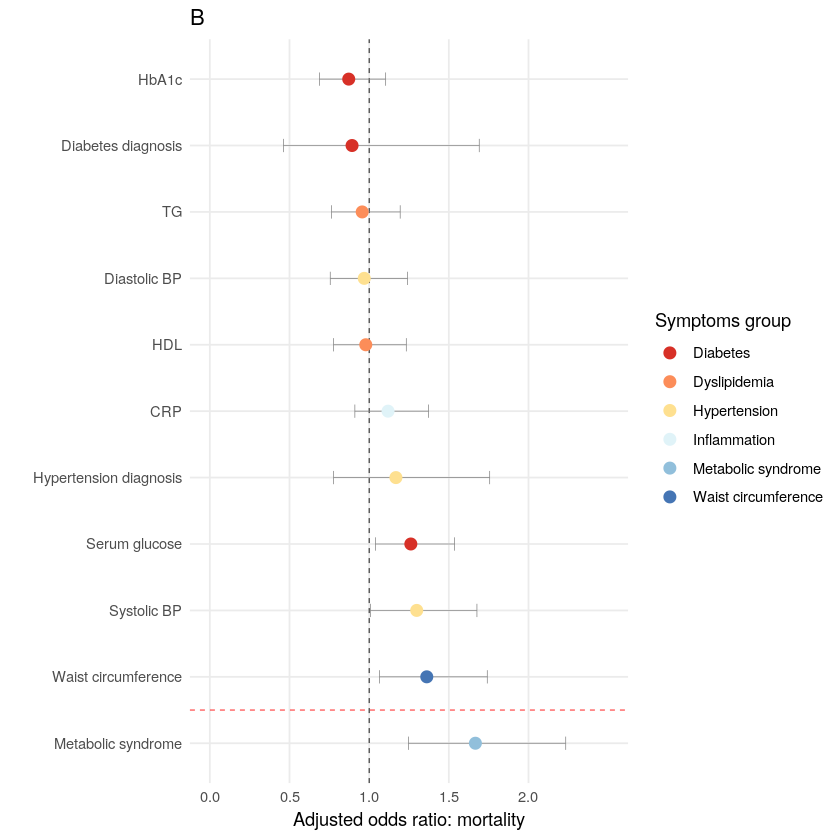

In [65]:
(p_death <- ggplot(ORs_mortality, aes(x = (V1), y = reorder(names, -V1))) + 
    geom_vline(aes(xintercept = 1), size = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmax = X97.5.., xmin = X2.5..), size = 0.2, height = 0.2, color = "gray50") +
    geom_point(size = 3, aes(color = Symptomsgroup)) +
    scale_x_continuous(breaks = c(0,0.5,1,1.5,2),
                       limits = c(0,2.5)) +
    theme_minimal() +
    theme(panel.grid.minor = element_blank()) +
    ylab("") +
    xlab("Adjusted odds ratio: mortality") + 
    ggtitle("B") +
    scale_color_brewer(palette="RdYlBu", name='Symptoms group') +
    geom_hline(aes(yintercept = 1.5), size = .25, color='red', linetype='dashed') 
 )

ggsave('/dagher/dagher11/filip/COVID/COVID_mortality.tiff',
  plot = p_death,
  device = 'tiff',
  scale = 1,
  width = 15,
  height = 10,
  units = 'cm',
  dpi = 300
)